In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
logins_df = pd.read_json('logins.json')
logins_df.index = logins_df['login_time']
logins_df.head()

,login_time
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


In [3]:
# No NaN values in the dataset
logins_df.isna().sum()

login_time    0
dtype: int64

# Exploratory Data Analysis

In [4]:
resampled_logins = logins_df.resample('15min').count()
resampled_logins.columns = ['count']
resampled_logins.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [5]:
resampled_logins.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


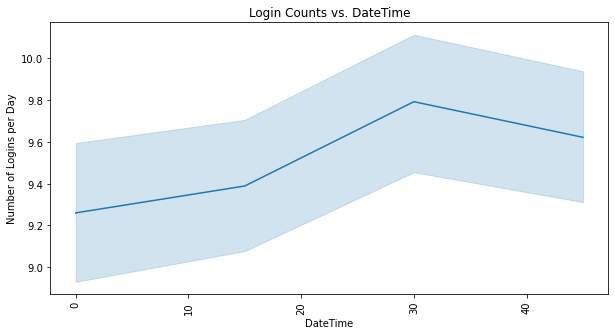

In [6]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=resampled_logins.index.minute, y='count', data=resampled_logins)
plt.xticks(rotation=90)
plt.xlabel('DateTime')
plt.ylabel('Number of Logins per Day')
plt.title('Login Counts vs. DateTime')
plt.show()

The graph above is a representation of what every 15 minutes looks like. Usually around the 30 minute mark wee get the most amount of logins.

In [7]:
daily_count = resampled_logins.resample('D').mean()

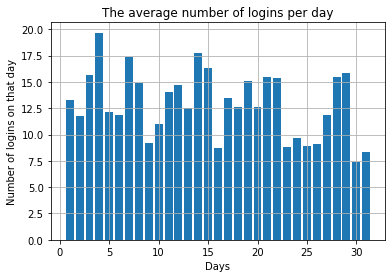

In [8]:
plt.bar(daily_count.index.day, daily_count['count'])
plt.xlabel('Days')
plt.ylabel('Number of logins on that day')
plt.title('The average number of logins per day')
plt.grid(True)
plt.show()

The bar graph shown above is a representation of what the average logins each day gets. The 4th day gets the most average logins.

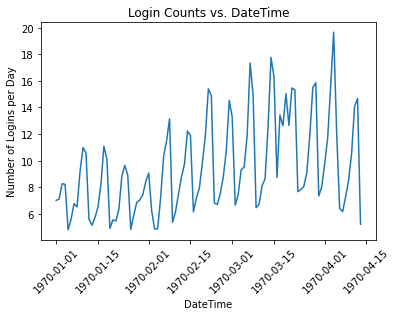

In [9]:
sns.lineplot(x=daily_count.index, y='count', data=daily_count)
plt.xticks(rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Number of Logins per Day')
plt.title('Login Counts vs. DateTime')
plt.show()

The graph above can show us that there are appears to be some patterns in the data. We can see how the trend is volatile because on some days we get a lot of logins but then on the next we see a drop on the number of logins.

The important features in this time series are the day because we can take each day and see how each day behaves towards the number of logins that we get.

# Part 2 - Experiment and metrics design

* When cost per trip is no longer an issue, the next key measure that I would consider would be time. This metric is important because a driver needs to be able to complete trips as fast as possible to be able to get new trips. Longer trips does not necessarily mean the most money making trips and so, one way to encourage drivers to work in both cities is by helping them reduce the time of getting from one city to the other.

* I would simulate data where all of the feauters are the same except for time and whether the trip is travelling to the other city or not. Then I would see whether they would still make as much or more money as staying in the same city.
    
        I can perform a permutation test where I can randomly subset data from the population dat. Then I can see whether the overall average in price is greater than or equal to the average price when the times are the same but they are travelling outside the city instead.
        
        If the tests proves that they are making more money when driving to the other city, then I would propsose for them to look into reducing traffic and to provide drivers with the most optimal routes so that they can finish their trips faster.

# Part 3 ‐ Predictive modeling

In [10]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [11]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [12]:
# Quantisize the categorical values and create a new category for NaN values
df['phone'] = df['phone'].replace({'iPhone': 0, 'Android': 1, np.NaN: 2})

In [13]:
def isna_col(df, col_name):
    if col_name == 'phone':
        isna = df['phone'].loc[df['phone'] == 2]
    else:
        isna = df.loc[df[col_name].isna()]
    na_ind = list(isna.index)
    new_col = [0 for _ in range(len(df))]
    for i in na_ind:
        new_col[i] = 1
    return new_col

In [14]:
# These columns will create new features that will give each entry a 1 or 0 depending on whether the 
# entry had a nan value on certain rows.
avg_of_isna = isna_col(df, 'avg_rating_of_driver')
phone_isna = isna_col(df, 'phone')
avg_by_isna = isna_col(df, 'avg_rating_by_driver')
temp_df = pd.DataFrame({'avg_rating_of_driver_isna': avg_of_isna,
                       'phone_isna': phone_isna,
                       'avg_rating_by_driver_isna': avg_by_isna})
df = df.join(temp_df)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,avg_rating_of_driver_isna,phone_isna,avg_rating_by_driver_isna
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,0,15.4,True,46.2,3.67,5.0,0,0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,1,0.0,False,50.0,8.26,5.0,0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,0,0.0,False,100.0,0.77,5.0,0,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,0,20.0,True,80.0,2.36,4.9,0,0,0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,1,11.8,False,82.4,3.13,4.9,0,0,0


In [15]:
# I will fill in NaN values using the column's mean
df = df.fillna(df.mean())
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver         0
avg_surge                    0
last_trip_date               0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver         0
avg_rating_of_driver_isna    0
phone_isna                   0
avg_rating_by_driver_isna    0
dtype: int64

In [16]:
# Data of when data was pulled
last_date = pd.to_datetime(df['last_trip_date']).max()

In [17]:
# This will provide the number of days since their last trip
retention = (last_date - pd.to_datetime(df['last_trip_date']))
retention.head()

0    14 days
1    57 days
2   175 days
3     2 days
4   108 days
Name: last_trip_date, dtype: timedelta64[ns]

In [18]:
for i in range(len(retention)):  
    if retention[i].days > 30:
        retention[i] = 0 * 1
    else:
        retention[i] = 1 * 1
# This will return a target column with the labels of whether they are 
# retained or not.
retention.head()

0    1
1    0
2    0
3    1
4    0
Name: last_trip_date, dtype: object

In [19]:
# Creates a new column for Retention
df = df.join(pd.DataFrame({'Retention': retention})['Retention'].astype('int'))
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,avg_rating_of_driver_isna,phone_isna,avg_rating_by_driver_isna,Retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,0,15.4,True,46.2,3.67,5.0,0,0,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,1,0.0,False,50.0,8.26,5.0,0,0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,0,0.0,False,100.0,0.77,5.0,0,0,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,0,20.0,True,80.0,2.36,4.9,0,0,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,1,11.8,False,82.4,3.13,4.9,0,0,0,0


In [20]:
# Next is to quantisize the city values
df['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [21]:
df['city'] = df['city'].replace({'''King's Landing''': 0, 'Astapor': 1, 'Winterfell': 2})
df['ultimate_black_user'] = df['ultimate_black_user'].replace({False: 0, True: 1})
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,avg_rating_of_driver_isna,phone_isna,avg_rating_by_driver_isna,Retention
0,0,4,2014-01-25,4.7,1.10,2014-06-17,0,15.4,1,46.2,3.67,5.0,0,0,0,1
1,1,0,2014-01-29,5.0,1.00,2014-05-05,1,0.0,0,50.0,8.26,5.0,0,0,0,0
2,1,3,2014-01-06,4.3,1.00,2014-01-07,0,0.0,0,100.0,0.77,5.0,0,0,0,0
3,0,9,2014-01-10,4.6,1.14,2014-06-29,0,20.0,1,80.0,2.36,4.9,0,0,0,1
4,2,14,2014-01-27,4.4,1.19,2014-03-15,1,11.8,0,82.4,3.13,4.9,0,0,0,0


In [22]:
print('{}% were retained'.format(round(df['Retention'].mean(), 4) * 100))

37.61% were retained


In [23]:
df.describe()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,avg_rating_of_driver_isna,phone_isna,avg_rating_by_driver_isna,Retention
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.264120,2.278200,4.601559,1.074764,0.316280,8.849536,0.37708,60.926084,5.796827,4.778158,0.162440,0.007920,0.004020,0.376080
std,0.774321,3.792684,0.564977,0.222336,0.481759,19.958811,0.48466,37.081503,5.707357,0.445753,0.368858,0.088642,0.063277,0.484405
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,4.500000,1.000000,0.000000,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,4.700000,1.000000,0.000000,0.000000,0.00000,66.700000,3.880000,5.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,3.000000,5.000000,1.050000,1.000000,8.600000,1.00000,100.000000,6.940000,5.000000,0.000000,0.000000,0.000000,1.000000
max,2.000000,125.000000,5.000000,8.000000,2.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
# Next steps are to one-hot encode categorical variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   city                       50000 non-null  int64  
 1   trips_in_first_30_days     50000 non-null  int64  
 2   signup_date                50000 non-null  object 
 3   avg_rating_of_driver       50000 non-null  float64
 4   avg_surge                  50000 non-null  float64
 5   last_trip_date             50000 non-null  object 
 6   phone                      50000 non-null  int64  
 7   surge_pct                  50000 non-null  float64
 8   ultimate_black_user        50000 non-null  int64  
 9   weekday_pct                50000 non-null  float64
 10  avg_dist                   50000 non-null  float64
 11  avg_rating_by_driver       50000 non-null  float64
 12  avg_rating_of_driver_isna  50000 non-null  int64  
 13  phone_isna                 50000 non-null  int

In [26]:
dummies = pd.get_dummies(df[['city', 'phone', 'ultimate_black_user']])
df = df.drop(['city', 'phone', 'ultimate_black_user'], axis=1)
df = df.join(dummies)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,avg_rating_of_driver_isna,phone_isna,avg_rating_by_driver_isna,Retention,city,phone,ultimate_black_user
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,0,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0,0,0,1,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,0,0,0,1,0,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,0,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,0,2,1,0


In [27]:
# This new feature will have the number of days the user used ultimate for
df['days_in_ultimate'] = (pd.to_datetime(df['last_trip_date']) - pd.to_datetime(df['signup_date'])).dt.days
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,avg_rating_of_driver_isna,phone_isna,avg_rating_by_driver_isna,Retention,city,phone,ultimate_black_user,days_in_ultimate
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,0,0,1,0,0,1,143
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0,0,0,1,1,0,96
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,0,0,0,1,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,0,0,1,0,0,1,170
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,0,2,1,0,47


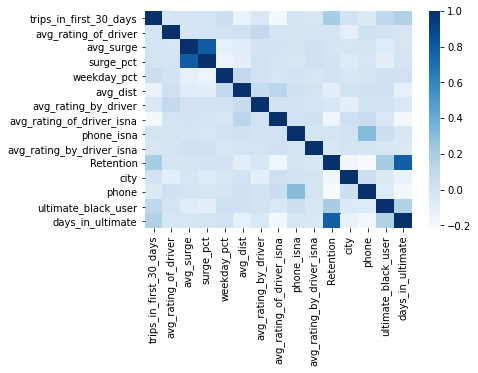

In [28]:
sns.heatmap(df.corr(), cmap='Blues')
plt.show()

In [29]:
df.corr()['Retention']

trips_in_first_30_days       0.210463
avg_rating_of_driver        -0.010829
avg_surge                   -0.003333
surge_pct                    0.011797
weekday_pct                  0.009693
avg_dist                    -0.092780
avg_rating_by_driver        -0.026748
avg_rating_of_driver_isna   -0.159232
phone_isna                  -0.007419
avg_rating_by_driver_isna   -0.025834
Retention                    1.000000
city                        -0.166180
phone                       -0.217287
ultimate_black_user          0.205002
days_in_ultimate             0.778522
Name: Retention, dtype: float64

According to the heat map, the most correlated features are ultimate_black_user, trips_in_first_30_days and days_in_ultimate. The heatmap then suggests that most of the other features have a negative correlation

Days in ultimate appears to give the most correlation to Retention

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [31]:
X = df.drop(['signup_date', 'last_trip_date', 'Retention'], axis=1)
y = df[['Retention']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42)

In [32]:
def run_model(X_train, y_train, X_test, y_test, model, params = {}):
    gs = GridSearchCV(model, param_grid=params, cv=5)
    gs.fit(X_train, y_train)
    return gs

In [33]:
logreg = run_model(X_train, y_train, X_test, y_test, LogisticRegression())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

In [34]:
logreg_pred = logreg.predict(X_test)
scores_dict = {'Logistic Regression':[precision_score(y_test, logreg_pred), recall_score(y_test, logreg_pred),
 f1_score(y_test, logreg_pred), accuracy_score(y_test, logreg_pred)]}

In [35]:
RandomForestClassifier()

RandomForestClassifier()

In [36]:
params = {'n_estimators': np.arange(1, 10),
          'max_depth': np.arange(1, 10),
         'criterion': ['gini', 'entropy']}
rfr = run_model(X_train, y_train, X_test, y_test, RandomForestClassifier(), params)
rfr_predict = rfr.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

In [37]:
scores_dict['RandomForestClassifier'] = [precision_score(y_test, rfr_predict), recall_score(y_test, rfr_predict),
 f1_score(y_test, rfr_predict), accuracy_score(y_test, rfr_predict)]

In [38]:
params = {'max_depth': np.arange(1, 10)}
tree = run_model(X_train, y_train, X_test, y_test, DecisionTreeClassifier(), params)
tree_predict = tree.predict(X_test)

In [39]:
scores_dict['DecisionTreeClassifier'] = [precision_score(y_test, tree_predict), recall_score(y_test, tree_predict),
 f1_score(y_test, tree_predict), accuracy_score(y_test, tree_predict)]

In [40]:
metrics_table = {'LogisticRegression': [np.NaN, np.NaN],
                'RandomForestClassifier': [rfr.best_params_['max_depth'], rfr.best_params_['n_estimators']],
                'DecisionTreeClassifier': [tree.best_params_['max_depth'], np.NaN]}
metrics_table = pd.DataFrame(metrics_table, index=['max_depth', 'n_estimators']).T
metrics_table

,max_depth,n_estimators
LogisticRegression,NaN,NaN
RandomForestClassifier,8.0,8.0
DecisionTreeClassifier,6.0,NaN


In [41]:
pd.DataFrame(scores_dict, index=['Precision', 'Recall', 'F1', 'Accuracy'])

,Logistic Regression,RandomForestClassifier,DecisionTreeClassifier
Precision,0.923528,0.936535,0.947669
Recall,0.951788,0.960861,0.943960
F1,0.937445,0.948542,0.945811
Accuracy,0.952400,0.960933,0.959467


The metric that is important here is the accuracy. Since we want to know whether a user will be correctly classified as a retained user or not. The best model for accuracy appears to be the DecisionTreeClassifier. It returned an accuracy score of 95.95%

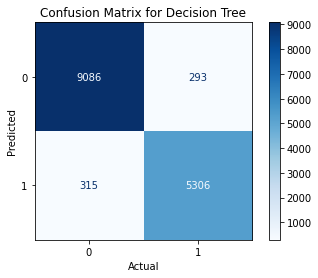

In [42]:
# The confusion matrix can provide better insights on how the predicted values are
plot_confusion_matrix(tree, X_test, y_test, cmap='Blues')  
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

The Decision Tree model is able to classify whether a person will remain retained with at least 95% confidence.

The company can use the model to generate their own data to see whether being a ultimate_black_user
really does increase their chances of using the app for longer. They can move their attention towards putting in promotions to have them gain extra money in the first 30 days since it seems like those who do well in the first 30 days tend to remain as users. 